# Problem Set up
## Biharmonic equation
$$
\Delta^2u = f\\
\Omega \in (0,1)*(0,1)\\
$$
### Boundary condition:
$$
u|_{\partial\Omega} = g_1, \frac{\partial u}{\partial n}|_{\partial\Omega} = g_2
$$
### Exact solution:
$$
u(x,y) = e^xsin\pi y
$$
### f dervived from u:
$$
f = u_{xxxx}+2u_{xxyy}+u_{yyyy} = e^xsin\pi y-2\pi^2e^xsin\pi y+\pi^4e^xsin\pi y
$$
### derivative on boundary:
$$
\frac{\partial u}{\partial n} = \nabla u\cdot \vec n = (\partial_x u,\partial_y u)\cdot\vec n\\
\nabla u = (e^xsin\pi y,\pi e^xcos\pi y)
$$

## Import Libraries

In [1]:
import torch
import torch.autograd as autograd #derive partial derivative
from torch import Tensor
import torch.nn as nn
import torch.optim as optim #optimization

import numpy as np
import time
from pyDOE import lhs
import scipy.io

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker

#Set default dtype to float 31
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

#Random number generation in other libraries
np.random.seed(1234)

#Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

if device == 'cuda':
    print(torch.cuda.get_device_name())

cuda


In [2]:
def plot3D(x,y,u):
    x_plot = x
    y_plot = y
    U = u
    X,Y = torch.meshgrid(x_plot,y_plot)
    fig,ax = plt.subplots(1,1)
    cp = ax.contourf(X,Y,U,20,cmap='rainbow')
    fig.colorbar(cp)
    ax.set_title('u(x,y)')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.show()
    ax = plt.axes(projection='3d')
    ax.plot_surface(X.numpy(), Y.numpy(), U.numpy(), cmap='rainbow')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('u(x,y)')
    plt.show()

In [3]:
def plot3D_Matrix(x,y,u):
    X,Y = x,y
    U = u
    fig,ax = plt.subplots(1,1)
    cp = ax.contourf(X,Y,U,20,cmap='rainbow')
    fig.colorbar(cp)
    ax.set_title('u(x,y)')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.show()
    ax = plt.axes(projection='3d')
    ax.plot_surface(X.numpy(), Y.numpy(), U.numpy(), cmap='rainbow')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('u(x,t)')
    plt.show()

## Generate and Visualize the DATA

In [4]:
def real(x,y):
    return torch.exp(x)*torch.sin(np.pi*y)

/home/tslin/anaconda3/envs/pytorch/lib/python3.10/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484803030/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


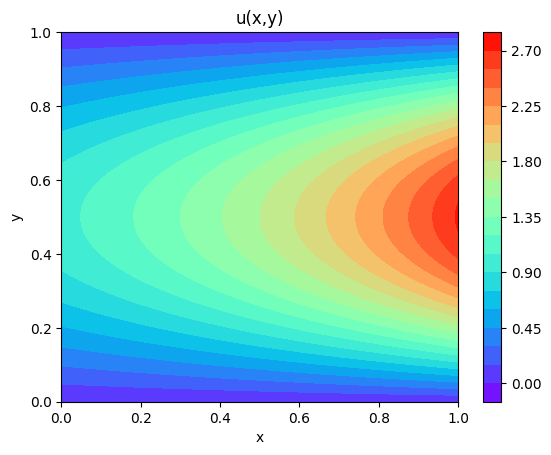

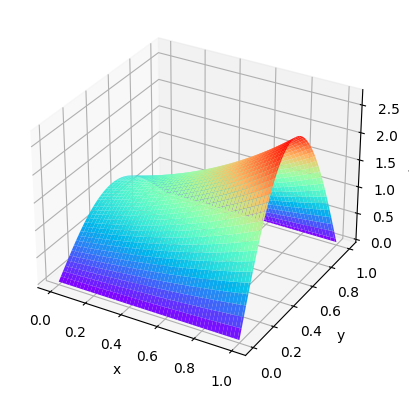

In [5]:
x = torch.linspace(0,1,100)
y = torch.linspace(0,1,100)
X,Y = torch.meshgrid(x,y)
u_real = real(X,Y)
plot3D(x,y,u_real)

## Testing Data

In [6]:
X.transpose(1,0).flatten().unsqueeze(1).shape

torch.Size([10000, 1])

In [7]:
x_test = torch.hstack((X.transpose(1,0).flatten().unsqueeze(1),Y.transpose(1,0).flatten().unsqueeze(1)))
# 1st column:x, 2nd column:y
y_test = u_real.transpose(1,0).flatten().unsqueeze(1) # true solution

lb = torch.tensor([0.0101,0.0101])
ub = torch.tensor([0.9899,0.9899])

print(x_test.shape,y_test.shape)
print(lb,ub)

torch.Size([10000, 2]) torch.Size([10000, 1])
tensor([0.0101, 0.0101]) tensor([0.9899, 0.9899])


## Training Data

In [8]:
Y[:,-1]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [13]:
X[-1,:]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [14]:
# Dirchlet boundary condition
left = torch.hstack((X[0,:][:,None],Y[0,:][:,None]))
left_u = torch.exp(left[:,0]).unsqueeze(1)*torch.sin(np.pi*left[:,1]).unsqueeze(1)

right = torch.hstack((X[-1,:][:,None],Y[0,:][:,None]))
right_u = torch.exp(right[:,0]).unsqueeze(1)*torch.sin(np.pi*right[:,1]).unsqueeze(1)

top = torch.hstack((X[:,0][:,None],Y[:,-1][:,None]))
top_u = torch.exp(top[:,0]).unsqueeze(1)*torch.sin(np.pi*top[:,1]).unsqueeze(1)

bottom = torch.hstack((X[:,0][:,None],Y[:,0][:,None]))
bottom_u = torch.exp(bottom[:,0]).unsqueeze(1)*torch.sin(np.pi*bottom[:,1]).unsqueeze(1)

X_train_D = torch.vstack((left,right,top,bottom))#(400,2)
Y_train_D = torch.vstack((left_u,right_u,top_u,bottom_u))#(400,1)

Nd = 100 # Dirchlet boundary points
idx = np.random.choice(X_train_D.shape[0],Nd,replace = False)

X_train_Nd = X_train_D[idx,:]
Y_train_Nd = Y_train_D[idx,:]

# Neuman boundary condition
left_u1 = -torch.exp(left[:,0]).unsqueeze(1)*torch.sin(np.pi*left[:,1]).unsqueeze(1)
right_u1 = torch.exp(right[:,0]).unsqueeze(1)*torch.sin(np.pi*right[:,1]).unsqueeze(1)
top_u1 = np.pi*torch.exp(top[:,0]).unsqueeze(1)*torch.cos(np.pi*top[:,1]).unsqueeze(1)
bottom_u1 = -np.pi*torch.exp(bottom[:,0]).unsqueeze(1)*torch.cos(np.pi*bottom[:,1]).unsqueeze(1)

Nn = 25 # Neuman boundary points for each edge
idx1 = np.random.choice(left_u1.shape[0],Nn,replace = False)
idx2 = np.random.choice(right_u1.shape[0],Nn,replace = False)
idx3 = np.random.choice(top_u1.shape[0],Nn,replace = False)
idx4 = np.random.choice(bottom_u1.shape[0],Nn,replace = False)

X_train_Nn_l = left[idx1,:] #(25,2)
Y_train_Nn_l = left_u1[idx1,:] #(25,1)

X_train_Nn_r = right[idx2,:]
Y_train_Nn_r = right_u1[idx2,:]

X_train_Nn_t = top[idx3,:]
Y_train_Nn_t = top_u1[idx3,:]

X_train_Nn_b = bottom[idx4,:]
Y_train_Nn_b = bottom_u1[idx4,:]

In [15]:
Y_train_Nn_l.shape

torch.Size([25, 1])

In [16]:
print(X_train_Nd.shape,Y_train_Nd.shape)

torch.Size([100, 2]) torch.Size([100, 1])


In [17]:
# Collocation points
Nf = 5000 # interior points
X_train_Nf = lb+(ub-lb)*lhs(2,Nf)# (5000,2)

In [18]:
print(X_train_Nf.shape)

torch.Size([5000, 2])


In [19]:
x_test = x_test.float().to(device)
y_test = y_test.float().to(device)

X_train_Nd = X_train_Nd.float().to(device)
Y_train_Nd = Y_train_Nd.float().to(device)

X_train_Nn_l = X_train_Nn_l.float().to(device)
Y_train_Nn_l = Y_train_Nn_l.float().to(device)

X_train_Nn_r = X_train_Nn_r.float().to(device)
Y_train_Nn_r = Y_train_Nn_r.float().to(device)

X_train_Nn_t = X_train_Nn_t.float().to(device)
Y_train_Nn_t = Y_train_Nn_t.float().to(device)

X_train_Nn_b = X_train_Nn_b.float().to(device)
Y_train_Nn_b = Y_train_Nn_b.float().to(device)

X_train_Nf = X_train_Nf.float().to(device)
f_hat = torch.zeros(X_train_Nf.shape[0],1).to(device)

## Neural Network

In [20]:
# construct a neural network
class FCN(nn.Module):
    def __init__(self,layers):
        super().__init__()
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction ='mean') 
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)]) 
        self.iter = 0 
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            nn.init.zeros_(self.linears[i].bias.data)
            
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        a = x.float()
        for i in range(len(layers)-2):  
            z = self.linears[i](a)              
            a = self.activation(z)    
        a = self.linears[-1](a)
        return a
    
## Loss on boundary
    # Dirchlet boundary condition
    def lossBC(self,x_BC,y_BC):
        loss_BC_d = self.loss_function(self.forward(x_BC),y_BC)
        return loss_BC_d
    
    # Neuman boundary condition
    def lossBC_n_r(self,x_BC):
        g = x_BC.clone()
        g.requires_grad = True
        u = self.forward(g)
        #partial u/partial x, partialu/partial y
        u_x_y = autograd.grad(outputs = u, inputs = g, grad_outputs= torch.ones_like(u), retain_graph=True,create_graph=True)[0]
        u_x = u_x_y[:,[0]]
        return self.loss_function(u_x,Y_train_Nn_r)
    
    def lossBC_n_l(self,x_BC):
        g = x_BC.clone()
        g.requires_grad = True
        u = self.forward(g)
        #partial u/partial x, partialu/partial y
        u_x_y = autograd.grad(outputs = u, inputs = g, grad_outputs= torch.ones_like(u), retain_graph=True,create_graph=True)[0]
        u_x = -1*u_x_y[:,[0]]
        return self.loss_function(u_x,Y_train_Nn_l)
    
    def lossBC_n_t(self,x_BC):
        g = x_BC.clone()
        g.requires_grad = True
        u = self.forward(g)
        #partial u/partial x, partialu/partial y
        u_x_y = autograd.grad(outputs = u, inputs = g, grad_outputs= torch.ones_like(u), retain_graph=True,create_graph=True)[0]
        u_y = u_x_y[:,[1]]
        return self.loss_function(u_y,Y_train_Nn_t)
    
    def lossBC_n_b(self,x_BC):
        g = x_BC.clone()
        g.requires_grad = True
        u = self.forward(g)
        #partial u/partial x, partialu/partial y
        u_x_y = autograd.grad(outputs = u, inputs = g, grad_outputs= torch.ones_like(u), retain_graph=True,create_graph=True)[0]
        u_y = -1*u_x_y[:,[1]]
        return self.loss_function(u_y,Y_train_Nn_b)
    
## Loss in interior
    def lossPDE(self,x_PDE):
        g = x_PDE.clone()
        g.requires_grad = True
        u = self.forward(g)
        u_x_y = autograd.grad(outputs = u, inputs = g, grad_outputs= torch.ones_like(u), retain_graph=True,create_graph=True)[0]
        
        u_xx_xy = autograd.grad(outputs = u_x_y[:,[0]], inputs = g, grad_outputs= torch.ones_like(u_x_y[:,[0]]), retain_graph=True,create_graph=True)[0]
        u_xxx_xxy = autograd.grad(u_xx_xy[:,[0]],g,grad_outputs=torch.ones_like(u_xx_xy[:,[0]]),retain_graph=True,create_graph=True)[0]
        u_xxyx_xxyy = autograd.grad(u_xxx_xxy[:,[1]],g,grad_outputs=torch.ones_like(u_xxx_xxy[:,[1]]),retain_graph=True,create_graph=True)[0]
        u_xxxx_xxxy = autograd.grad(u_xxx_xxy[:,[0]],g,grad_outputs=torch.ones_like(u_xxx_xxy[:,[0]]),retain_graph=True,create_graph=True)[0]
        
        u_yx_yy = autograd.grad(outputs = u_x_y[:,[1]], inputs = g, grad_outputs= torch.ones_like(u_x_y[:,[1]]), retain_graph=True,create_graph=True)[0]
        u_yyx_yyy = autograd.grad(u_yx_yy[:,[1]],g,grad_outputs=torch.ones_like(u_yx_yy[:,[1]]),retain_graph=True,create_graph=True)[0]
        u_yyyx_yyyy = autograd.grad(u_yyx_yyy[:,[1]],g,grad_outputs=torch.ones_like(u_yyx_yyy[:,[1]]),retain_graph=True,create_graph=True)[0]
        
        u_xxxx = u_xxxx_xxxy[:,[0]]
        u_xxyy = u_xxyx_xxyy[:,[1]]
        u_yyyy = u_yyyx_yyyy[:,[1]]
        
        #f = (torch.exp(g[:,0:1])*torch.sin(np.pi*g[:,1:]))- (2*(np.pi**2)*torch.exp(g[:,0:1])*torch.sin(np.pi*g[:,1:]))+ (np.pi**4*torch.exp(g[:,0:1])*torch.sin(np.pi*g[:,1:]))
        F1 = u_xxxx-(torch.exp(x_PDE[:,0:1])*torch.sin(np.pi*x_PDE[:,1:]))
        F2 = 2*u_xxyy+ (2*(np.pi**2)*torch.exp(x_PDE[:,0:1])*torch.sin(np.pi*x_PDE[:,1:]))
        F3 = u_yyyy- (np.pi**4*torch.exp(x_PDE[:,0:1])*torch.sin(np.pi*x_PDE[:,1:]))
        F = F1+F2+F3
        return self.loss_function(F,f_hat)
    
## Total loss
    def loss(self,x_BC,y_BC,x_BC1,x_BC2,x_BC3,x_BC4,x_in):
        loss1 = self.lossBC(x_BC,y_BC)
        loss2 = self.lossBC_n_r(x_BC1)
        loss3 = self.lossBC_n_l(x_BC2)
        loss4 = self.lossBC_n_t(x_BC3)
        loss5 = self.lossBC_n_b(x_BC4)
        loss6 = self.lossPDE(x_in)
        return loss1+loss2+loss3+loss4+loss5+loss6
    
##Optimizer
    def closure(self):
        optimizer.zero_grad()
        loss = self.loss(X_train_Nd,Y_train_Nd,X_train_Nn_r,X_train_Nn_l,X_train_Nn_t,X_train_Nn_b,X_train_Nf)
        loss.backward()
        self.iter += 1
        if self.iter % 100 ==0:
            loss2=self.lossBC(X_test,Y_test)
            print("Training Error:",loss.detach().cpu().numpy(),"---Testing Error:",loss2.detach().cpu().numpy())
            return loss

## Training

In [34]:
layers = np.array([2,20,20,20,20,20,1])
PINN = FCN(layers)
PINN.to(device)
print(PINN)

FCN(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=20, bias=True)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=20, bias=True)
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Linear(in_features=20, out_features=1, bias=True)
  )
)


In [35]:
X_train_Nf

tensor([[0.4301, 0.3593],
        [0.1526, 0.0933],
        [0.3265, 0.4393],
        ...,
        [0.7820, 0.7060],
        [0.6024, 0.8388],
        [0.4546, 0.8213]], device='cuda:0')

In [36]:
PINN.lossBC(X_train_Nd,Y_train_Nd)

tensor(0.8067, device='cuda:0', grad_fn=<MseLossBackward0>)

In [37]:
PINN.lossBC_n_b(X_train_Nn_b)

tensor(32.3729, device='cuda:0', grad_fn=<MseLossBackward0>)

In [38]:
PINN.lossPDE(X_train_Nf)

tensor(9648.3008, device='cuda:0', grad_fn=<MseLossBackward0>)

In [39]:
optimizer = torch.optim.LBFGS(
    PINN.parameters(), 
    lr=0.1, 
    max_iter=10000, 
    max_eval=10000, 
    history_size=50,
    line_search_fn="strong_wolfe"       # can be "strong_wolfe"
)

In [40]:
def closure():
    optimizer.zero_grad()
    global itera
    itera+=1
    
    loss = PINN.loss(X_train_Nd,Y_train_Nd,X_train_Nn_r,X_train_Nn_l,X_train_Nn_t,X_train_Nn_b,X_train_Nf)
    test_loss = PINN.lossBC(x_test,y_test)
    
    if itera % 100 == 0:
        print(
            'Iter %5d, Training loss : %.5e, Testing Loss : %.5e' % (itera, loss.item(), test_loss.item())
            )
    
    loss.backward(retain_graph=True)
    return loss

In [41]:
import time
start = time.time()
itera = 0

PINN.train()

loss =  PINN.loss(X_train_Nd,Y_train_Nd,X_train_Nn_r,X_train_Nn_l,X_train_Nn_t,X_train_Nn_b,X_train_Nf)
test_loss = PINN.lossBC(x_test,y_test)

print('Iter %5d, Training loss : %.5e, Testing Loss : %.5e' % (itera, loss.item(), test_loss.item()))

optimizer.step(closure)
end = time.time()
print(end-start)

Iter     0, Training loss : 9.71139e+03, Testing Loss : 9.37370e-01
Iter   100, Training loss : 6.59917e+01, Testing Loss : 2.63260e+00
Iter   200, Training loss : 8.58827e+00, Testing Loss : 3.08442e-01
Iter   300, Training loss : 4.60580e+00, Testing Loss : 8.96520e-02
Iter   400, Training loss : 3.38551e+00, Testing Loss : 4.99338e-02
Iter   500, Training loss : 2.37978e+00, Testing Loss : 1.54172e-02
Iter   600, Training loss : 1.82387e+00, Testing Loss : 2.46770e-02
Iter   700, Training loss : 1.34368e+00, Testing Loss : 3.93610e-02
Iter   800, Training loss : 1.09697e+00, Testing Loss : 2.48852e-02
Iter   900, Training loss : 9.85963e-01, Testing Loss : 1.38718e-02
Iter  1000, Training loss : 8.26488e-01, Testing Loss : 2.86045e-02
Iter  1100, Training loss : 7.22378e-01, Testing Loss : 1.01386e-02
Iter  1200, Training loss : 6.76156e-01, Testing Loss : 8.23665e-03
Iter  1300, Training loss : 6.35053e-01, Testing Loss : 5.36551e-03
Iter  1400, Training loss : 6.03341e-01, Testing

In [30]:
u1 = PINN(x_test)
x1 = x_test[:,0]
y1 = x_test[:,1]

In [31]:
arr_x1 = x1.reshape(shape = [100,100]).transpose(1,0).detach().cpu()
arr_y1 = y1.reshape(shape = [100,100]).transpose(1,0).detach().cpu()
arr_u1 = u1.reshape(shape = [100,100]).transpose(1,0).detach().cpu()

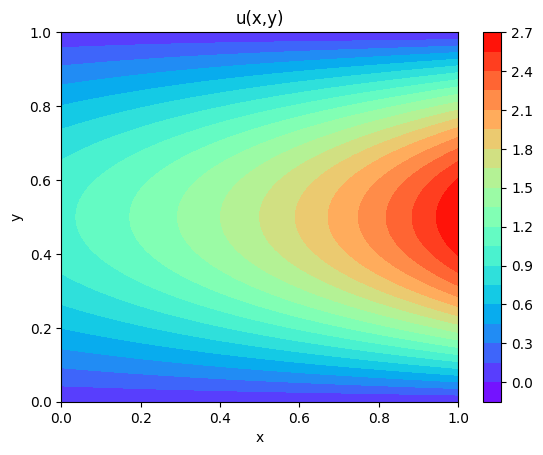

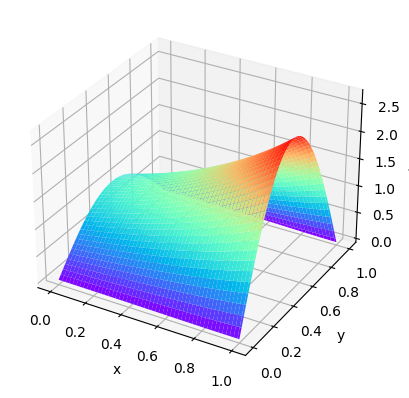

In [32]:
plot3D_Matrix(arr_x1,arr_y1,arr_u1)

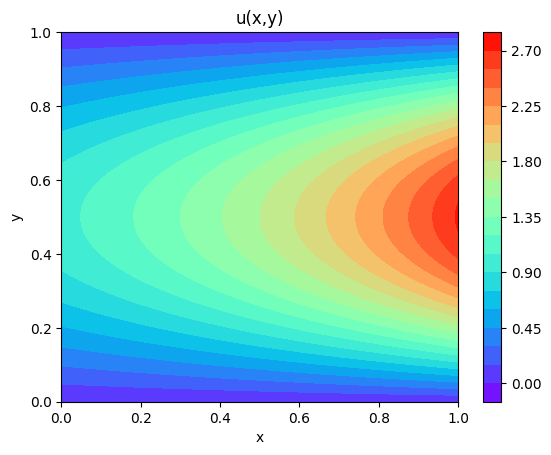

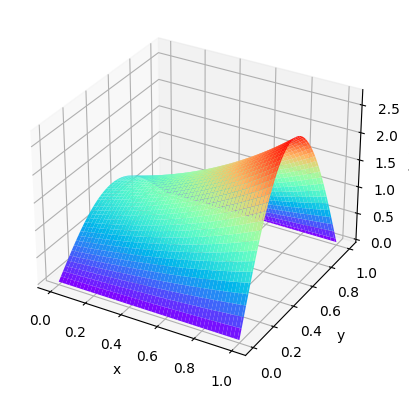

In [33]:
plot3D_Matrix(X,Y,u_real)